In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from langchain_core.tools import tool
from typing import TypedDict,Annotated
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_core.messages import HumanMessage,BaseMessage
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage,ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command


In [2]:
load_dotenv()

True

In [3]:
# web search tool 
from langchain_tavily import TavilySearch
web_search_tool = TavilySearch(max_results=2)

In [4]:
# File management tool
from langchain_community.agent_toolkits import FileManagementToolkit

working_directory = './files'

file_management_tools =FileManagementToolkit(
    root_dir=str(working_directory),
    selected_tools=["read_file", "write_file", "list_directory"]
).get_tools()


read_tool, write_tool, list_tool = file_management_tools

In [5]:
from langchain_core.tools import BaseTool,tool
from langgraph.prebuilt.interrupt import HumanInterruptConfig,HumanInterrupt
from langchain_core.runnables import RunnableConfig
from langgraph.types import interrupt

In [6]:
def add_human_in_the_loop(toolhitl,interrupt_config: HumanInterruptConfig = None) -> BaseTool:
    """Wrap a tool to support human-in-the-loop review."""

    if not isinstance(toolhitl, BaseTool):
        toolhitl = tool(toolhitl)

    if interrupt_config is None:
        interrupt_config = {
            "allow_accept":True,
            "allow_edit": True,
            "allow_respond":True
        }

    @tool(toolhitl.name,description=toolhitl.description,args_schema=toolhitl.args_schema)
    def call_tool_with_interrupt(config: RunnableConfig, **tool_input):
        request: HumanInterrupt = {
            'action_request':{
                "action":toolhitl.name,
                "args":tool_input
            },
            "config":interrupt_config,
            "description": "Please review the tool call"
        }

        response = interrupt([request])[0]

        # approve the tool call
        if response["type"] == "accept":
            tool_response = toolhitl.invoke(tool_input, config)
        # update tool call args
        elif response["type"] == "edit":
            tool_input = response["args"]["args"]
            tool_response = toolhitl.invoke(tool_input, config)
        # respond to the LLM with user feedback
        elif response["type"] == "response":
            user_feedback = response["args"]
            tool_response = user_feedback
        else:
            raise ValueError(f"Unsupported interrupt response type: {response['type']}")

        return tool_response
    
    return call_tool_with_interrupt




In [7]:
#arxiv
import arxiv

@tool("arxiv_search")
def arxiv_search(query: str,max_results: int = 5) -> str:
    """
    Searches arXiv for papers matching the query.
    - query: keywords, authors or title
    - max_results: number of papers to return
    """
    try:
        search = arxiv.Search(
            query=query,
            max_results=max_results,
            sort_by=arxiv.SortCriterion.Relevance
        )
        papers = []
        for result in search.results():
            pdf_url = result.pdf_url if hasattr(result,"pdf_url") else result.entry_id.replace("abs","pdf")
            papers.append(
                f"Title: {result.title}\n"
                f"Authors: {','.join(a.name for a in result.authors)}\n"
                f'Published: {result.published.date()}\n'
                f"Abstract: {result.summary.strip()}\n"
                f"Link: {result.entry_id}\n"
                f"PDF: {pdf_url}\n"
                + "-"*80

            )
        if not papers:
            return f"No results found for '{query}"
        return "\n".join(papers)
    except Exception as e:
        return f"Error during arXiv search: {e}"
    



In [8]:
result = arxiv_search("Quantum Machine Learning")

C:\Users\JunaidKhan\AppData\Local\Temp\ipykernel_16152\2627632007.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = arxiv_search("Quantum Machine Learning")
C:\Users\JunaidKhan\AppData\Local\Temp\ipykernel_16152\2323917343.py:18: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


In [9]:
#wikipedia
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(load_all_available_meta=True))

In [10]:
#youtube
from langchain_community.tools import YouTubeSearchTool
youtube_tool = YouTubeSearchTool()

In [11]:
youtube_tool.run("CampusX")

"['https://www.youtube.com/watch?v=4FFspU4riHk&pp=ygUHQ2FtcHVzWA%3D%3D', 'https://www.youtube.com/watch?v=g8zA76oBmX0&pp=ygUHQ2FtcHVzWNIHCQmyCQGHKiGM7w%3D%3D']"

In [12]:
# tools
tools = [arxiv_search,wikipedia_tool,youtube_tool,read_tool, add_human_in_the_loop(write_tool), list_tool,web_search_tool]

In [13]:
#llm
llm = ChatGoogleGenerativeAI(model = 'gemini-1.5-flash')
llm_with_tools = llm.bind_tools(tools)


GRAPH BUILDING

In [14]:
class State(TypedDict):
    messages : Annotated[list[BaseMessage],add_messages]

In [15]:
system_prompt = """ 
You are a reasoning agent that uses tools to answer questions.
You must always follow the Thought → Action → Action Input → Observation loop.

"""

In [16]:
def planner_node(state):
    user_query = state['messages']

    planner_prompt = ChatPromptTemplate([
        ('system',system_prompt),
        MessagesPlaceholder(variable_name='messages')
    ])

    planner = planner_prompt | llm_with_tools
    result = planner.invoke({'messages': state['messages']})


    return ({'messages':result}) 
    

In [17]:
graph = StateGraph(State)
checkpointer = InMemorySaver()
tool_node = ToolNode(tools)
graph.add_node('planner_node',planner_node)
graph.add_node('tools',tool_node)

graph.add_edge(START,'planner_node')
graph.add_conditional_edges('planner_node',tools_condition)
graph.add_edge('tools','planner_node')
graph = graph.compile(checkpointer=checkpointer)

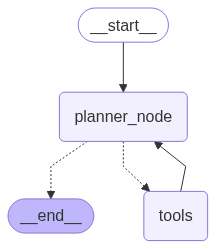

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
initial_state = {
    "messages": [HumanMessage(content="save a python file to check if number is divisible by 17 or not")]
}

config = {"configurable": {"thread_id": "ss9vljk"}}

In [31]:
event = graph.stream(
    initial_state,
    config=config,
    stream_mode="updates",
)

In [26]:
eventin = graph.invoke(
    initial_state,
    config=config,
)

In [27]:
eventin

{'messages': [HumanMessage(content='save a python file to check if number is divisible by 17 or not', additional_kwargs={}, response_metadata={}, id='4e17be49-8792-466f-ba0d-0f5fe5112fc0'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'write_file', 'arguments': '{"file_path": "divisible_by_17.py", "text": "def is_divisible_by_17(number):\\n    return number % 17 == 0\\n\\n# Example usage\\nnumber = 51  # Replace with the number you want to check\\nif is_divisible_by_17(number):\\n    print(f\'{number} is divisible by 17\')\\nelse:\\n    print(f\'{number} is not divisible by 17\')"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--ce71f5eb-2a69-4bfe-8675-52c5de1a4489-0', tool_calls=[{'name': 'write_file', 'args': {'file_path': 'divisible_by_17.py', 'text': "def is_divisible_by_17(number):\n    return number % 17 == 0\n\n# Example usage\nn

In [156]:
for e in event:
    print(e)

{'planner_node': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'wikipedia', 'arguments': '{"query": "Naruto"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--7ddfec85-56f0-4b2a-b102-e32252c81153-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Naruto'}, 'id': 'f7c235d5-d29c-4eb2-af44-358efcdc2ddb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1699, 'output_tokens': 75, 'total_tokens': 1774, 'input_token_details': {'cache_read': 1645}, 'output_token_details': {'reasoning': 61}})}}
{'tools': {'messages': [ToolMessage(content='Page: Naruto\nSummary: Naruto is a Japanese manga series written and illustrated by Masashi Kishimoto. It tells the story of Naruto Uzumaki, a young ninja who seeks recognition from his peers and dreams of becoming the Hokage, the leader of his village. The story is told in two parts: the 

In [ ]:
for e in event:
    if "__interrupt__" not in e:
        print("ok")
        for node,data in e.items():
        
            m = data.get('messages',[])
            if isinstance(m, ToolMessage):
                print('working')
                print(m)


ok
ok
ok


In [ ]:
{'name':{'messages':}}

In [ ]:
for e in event:
    if "__interrupt__" in e:
        print(e['__interrupt__'][0])

{'action_request': {'action': 'write_file', 'args': {'file_path': 'divisible_by_17.py', 'text': 'def is_divisible_by_17(number):\n    return number % 17 == 0\n\n# Get input from the user\nnumber = int(input("Enter a number: "))\n\n# Check if the number is divisible by 17\nif is_divisible_by_17(number):\n    print(f"{number} is divisible by 17.")\nelse:\n    print(f"{number} is not divisible by 17.")'}}, 'config': {'allow_accept': True, 'allow_edit': True, 'allow_respond': True}, 'description': 'Please review the tool call'}


In [34]:
print(graph.get_state(config))

StateSnapshot(values={'messages': [HumanMessage(content='save a python file to check if number is divisible by 17 or not', additional_kwargs={}, response_metadata={}, id='4abbc521-9020-48a7-939e-b77a796099ff'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'write_file', 'arguments': '{"file_path": "divisible_by_17.py", "text": "def is_divisible_by_17(number):\\n    return number % 17 == 0\\n\\n#Example usage\\nnumber = 51\\nif is_divisible_by_17(number):\\n    print(f\\"{number} is divisible by 17\\")\\nelse:\\n    print(f\\"{number} is not divisible by 17\\")"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--93701ff0-f4c9-429e-9fa4-b05c73072bdf-0', tool_calls=[{'name': 'write_file', 'args': {'file_path': 'divisible_by_17.py', 'text': 'def is_divisible_by_17(number):\n    return number % 17 == 0\n\n#Example usage\nnumber = 51\nif is_divisi

In [33]:
for e in event:
    if "__interrupt__" in e:
        print(e['__interrupt__'][0].id)

b0833a6953b0991e205914b129c2cdfc


In [34]:
for message_chunk, metadata in graph.stream(
    initial_state,
    config=config,
    stream_mode="messages",
):
    print(message_chunk)
    print("----------------------")
    print(metadata)
    print("***********************")


content='' additional_kwargs={'function_call': {'name': 'wikipedia', 'arguments': '{"query": "pyramids"}'}} response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--75a7046e-f2ab-4b58-b4ae-6f1ee1b8a93a' tool_calls=[{'name': 'wikipedia', 'args': {'query': 'pyramids'}, 'id': '6031f234-0cda-46a1-ad5b-36b0df9ea487', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1698, 'output_tokens': 79, 'total_tokens': 1777, 'input_token_details': {'cache_read': 1644}, 'output_token_details': {'reasoning': 64}} tool_call_chunks=[{'name': 'wikipedia', 'args': '{"query": "pyramids"}', 'id': '6031f234-0cda-46a1-ad5b-36b0df9ea487', 'index': None, 'type': 'tool_call_chunk'}]
----------------------
{'thread_id': '9d0', 'langgraph_step': 1, 'langgraph_node': 'planner_node', 'langgraph_triggers': ('branch:to:planner_node',), 'langgraph_path': ('__pregel_pull', 'planner_node'), 'langgraph_checkpoint_ns': 'planner_node:d66173b5-000e-d444-9611-e16e1efc0b03'

In [43]:
for event in events:
    print(event)

In [26]:
# Run the agent
chunk =  graph.invoke(
    initial_state,
    config
)

In [30]:
chunk['messages'][-1].content

'Pyramids are monumental structures with triangular sides converging at an apex, often built by ancient civilizations. The majority of their mass is concentrated near the ground, allowing for stable and massive constructions. The Great Pyramid of Cholula in Mexico is the largest by volume, while the Great Pyramid of Khufu in Egypt was the tallest structure for millennia and is the only remaining Ancient Wonder of the World. Most Egyptian pyramids served as tombs for pharaohs and their consorts during the Old and Middle Kingdom periods. The Giza pyramid complex, home to the Great Pyramid, the Pyramid of Khafre, and the Pyramid of Menkaure, is a famous example of these ancient architectural marvels.'

In [38]:
chunk

{'__interrupt__': (Interrupt(value=[{'action_request': {'action': 'write_file', 'args': {'file_path': 'pyramid_info.txt', 'text': 'Pyramid: A pyramid is a structure whose visible surfaces are triangular in broad outline and converge toward the top, making the appearance roughly a pyramid in the geometric sense. The base of a pyramid can be of any polygon shape. Ancient civilizations in many parts of the world pioneered the building of pyramids. The largest pyramid by volume is the Mesoamerican Great Pyramid of Cholula, in the Mexican state of Puebla. For millennia, the largest structures on Earth were pyramids—first the Red Pyramid in the Dashur Necropolis and then the Great Pyramid of Khufu, both in Egypt.\n\nGreat Pyramid of Giza: The Great Pyramid of Giza is the largest Egyptian pyramid. It served as the tomb of pharaoh Khufu, who ruled during the Fourth Dynasty of the Old Kingdom. Built c. 2600 BC, over a period of about 26 years, the pyramid is the oldest of the Seven Wonders of t

In [ ]:
print(chunk['__interrupt__'][0])


(Interrupt(value=[{'action_request': {'action': 'write_file', 'args': {'file_path': 'pyramid_info.txt', 'text': 'Pyramid: A pyramid is a structure whose visible surfaces are triangular in broad outline and converge toward the top, making the appearance roughly a pyramid in the geometric sense. The base of a pyramid can be of any polygon shape. Ancient civilizations in many parts of the world pioneered the building of pyramids. The largest pyramid by volume is the Mesoamerican Great Pyramid of Cholula, in the Mexican state of Puebla. For millennia, the largest structures on Earth were pyramids—first the Red Pyramid in the Dashur Necropolis and then the Great Pyramid of Khufu, both in Egypt.\n\nGreat Pyramid of Giza: The Great Pyramid of Giza is the largest Egyptian pyramid. It served as the tomb of pharaoh Khufu, who ruled during the Fourth Dynasty of the Old Kingdom. Built c. 2600 BC, over a period of about 26 years, the pyramid is the oldest of the Seven Wonders of the Ancient World, 

In [28]:
from langgraph.types import Command
user_input = input("Do you accept: ?")

for chunk in graph.stream(
    Command(resume=[{"type": user_input}]),
    config
):
    print(chunk)
    print("\n")

{'tools': {'messages': [ToolMessage(content='File written successfully to divisible_by_17.py.', name='write_file', id='b6e55b91-ea4e-47b0-a824-da842ea24db3', tool_call_id='1c61f329-3a11-4809-90ac-2a300fc32076')]}}


{'planner_node': {'messages': AIMessage(content='I have created a Python file named `divisible_by_17.py` that contains a function `is_divisible_by_17` which checks if a given number is divisible by 17.  The file also includes example usage.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--4462c1c1-4548-4d6d-b5ef-1ce1828259e9-0', usage_metadata={'input_tokens': 1486, 'output_tokens': 55, 'total_tokens': 1541, 'input_token_details': {'cache_read': 0}})}}




In [24]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='tell me about pyramid in detail and save it in a txt file', additional_kwargs={}, response_metadata={}, id='3d461e2c-da90-4ac8-a295-a358610987ae'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'wikipedia', 'arguments': '{"query": "pyramid"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--49e40eaf-89df-4ccd-adbb-30b829354499-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'pyramid'}, 'id': '613a6772-c5b7-4248-a375-c8da09528e03', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1696, 'output_tokens': 63, 'total_tokens': 1759, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 49}}), ToolMessage(content='Page: Pyramid\nSummary: A pyramid (from Ancient Greek  πυραμίς (puramís) \'pyramid\', from the Egyptian pir-em-us, the vertical height of the